# Predicting <sup>13</sup>C NMR shifts of organic molecules

The goal of this project is to predict <sup>13</sup>C NMR chemical shifts in organic molecules. To each carbon atom in a molecule corresponds a chemical shift, which is linked to the local magnetic field experienced by that nucleus, and is therefore linked to the chemical environment: neighboring atoms, type of bonds, etc.

We use data from the [nmrshiftdb2 project](https://nmrshiftdb.nmr.uni-koeln.de/nmrshiftdb/media-type/html/user/anon/page/default.psml/js_pane/portal/js_pane/P-Help;jsessionid=B237E9AB49EB45D0F9E560719C792E4A?URL=t1.html#about), an open database for organic structures and their nuclear magnetic resonance (NMR) spectra.

This project has taken inspiration from various sources:
- The preprint [“NMR shift prediction from small data quantities”](https://doi.org/10.48550/arXiv.2304.03361), on arXiv.
- The [associated python code](https://colab.research.google.com/drive/1yKTRjpWzR8T199eCokuJfd9Y5o2oNtPp#scrollTo=wha6jaKTZlUX)
- A Master thesis: [“Prediction of 1H and 13C NMR Chemical Shifts of Small Molecules Using Machine Learning”](https://era.library.ualberta.ca/items/48539bc5-c67e-47f2-97f4-afe6594b6dca), by Zinat Sayeeda (University of Alberta)

In [1]:
import math
import mendeleev
import os
import pandas as pd
import random
import requests

# Specify a seed, so pseudo-random numbers are the same and the notebook is reproducible
random.seed("Call me Ishmael.")

## Content of the dataset

We first download the current version of the nmrshiftdb2 database: at the time of writing this notebook, the latest version available is dated 2023-01-25.

Because the data file is large (around 200 MB), we will only download it once, and then save it to disk. If you re-run this notebook later, the download will be skipped.

In [2]:
DATA_URL = "https://sourceforge.net/projects/nmrshiftdb2/files/data/nmrshiftdb2.nmredata.sd/download"
DATA_FILE = "nmrshiftdb2.nmredata.sd"

if not os.path.isfile(DATA_FILE):
    print("Downloading data file (large file: 200 MB)")
    r = requests.get(DATA_URL, allow_redirects=True)
    with open(DATA_FILE, "wb") as f:
        f.write(r.content)
        print("File saved")
else:
    print("Data file already present")

Data file already present


In [3]:
from rdkit import Chem
molecules = list(Chem.SDMolSupplier(DATA_FILE))
print(f"{len(molecules)} molecules read")

[16:47:51] Explicit valence for atom # 4 N, 4, is greater than permitted
[16:47:51] ERROR: Could not sanitize molecule ending on line 2496171
[16:47:51] ERROR: Explicit valence for atom # 4 N, 4, is greater than permitted
[16:47:51] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:47:51] ERROR: Could not sanitize molecule ending on line 2496259
[16:47:51] ERROR: Explicit valence for atom # 1 N, 4, is greater than permitted
[16:47:51] Explicit valence for atom # 3 H, 3, is greater than permitted
[16:47:51] ERROR: Could not sanitize molecule ending on line 2569602
[16:47:51] ERROR: Explicit valence for atom # 3 H, 3, is greater than permitted
[16:47:51] Explicit valence for atom # 3 H, 3, is greater than permitted
[16:47:51] ERROR: Could not sanitize molecule ending on line 2569689
[16:47:51] ERROR: Explicit valence for atom # 3 H, 3, is greater than permitted
[16:47:51] Explicit valence for atom # 0 N, 4, is greater than permitted
[16:47:51] ERROR: Could not sanitize mo

50217 molecules read


[16:47:54] Explicit valence for atom # 0 B, 4, is greater than permitted
[16:47:54] ERROR: Could not sanitize molecule ending on line 6030093
[16:47:54] ERROR: Explicit valence for atom # 0 B, 4, is greater than permitted
[16:47:54] WARNING: not removing hydrogen atom without neighbors
[16:47:54] Explicit valence for atom # 5 Cl, 2, is greater than permitted
[16:47:54] ERROR: Could not sanitize molecule ending on line 6030141
[16:47:54] ERROR: Explicit valence for atom # 5 Cl, 2, is greater than permitted
[16:47:54] WARNING: not removing hydrogen atom without neighbors
[16:47:54] Explicit valence for atom # 5 Cl, 2, is greater than permitted
[16:47:54] ERROR: Could not sanitize molecule ending on line 6030191
[16:47:54] ERROR: Explicit valence for atom # 5 Cl, 2, is greater than permitted
[16:47:54] WARNING: not removing hydrogen atom without neighbors
[16:47:54] WARNING: not removing hydrogen atom without neighbors
[16:47:54] Explicit valence for atom # 1 H, 2, is greater than permitt

We have used the [rdkit](https://www.rdkit.org/) module to read all the molecules and the associated information. We see it is a rich data set, with more then 50,000 molecules! Like all real data sets, it also contains some weird or erroneous data: rdkit has warnings or errors for some molecules. But let us have a look at what data is available for these molecules. Jupyter knows how to display the molecules and their associated data:

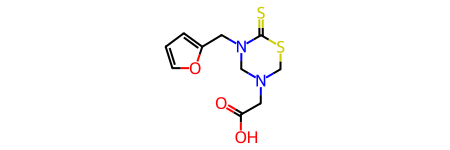

In [4]:
molecules[19]

We see that the 2D molecular structure is present, as well as some metadata associated with the NMR information. That data is in a series of fields, prefixed with `NMREDATA_`, in a format that is not immediately obvious. It is documented in this associated paper: [“NMReDATA, a standard to report the NMR assignment and parameters of organic compounds”](https://hal.science/hal-01904910/), which I encourage you to read. Some fields are easy:
- `NMREDATA_ID` relates to the identifier of this molecule in the database
- `NMREDATA_SMILES` and `NMREDATA_INCHI` are two representations of the identity of the molecule
- `NMREDATA_SOLVENT` is the solvent used for the measurement
- `NMREDATA_1D_13C` contains a <sup>13</sup>C NMR spectrum, with what seems to be values of chemical shifts
- `NMREDATA_ASSIGNMENT` has a list of signals, chemical shifts, and corresponding atom number (the assignment of the signals in the spectrum to individual atoms)

We will need to extract this information and process it to make it suitable for our learning task.

In [5]:
# We can get a single property as a string
molecules[19].GetProp("NMREDATA_ASSIGNMENT")

's0, 46.6, 12\\\ns1, 50.4, 14\\\ns2, 58.5, 4\\\ns3, 69.0, 2\\\ns4, 109.7, 10\\\ns5, 110.6, 11\\\ns6, 143.0, 7\\\ns7, 148.7, 9\\\ns8, 170.4, 15\\\ns9, 191.6, 6\\'

In [6]:
# Or all properties at once, as a dictionary
molecules[19].GetPropsAsDict()

{'NMREDATA_VERSION': '1.1\\',
 'NMREDATA_SOLVENT': 'Unreported\\',
 'NMREDATA_ASSIGNMENT': 's0, 46.6, 12\\\ns1, 50.4, 14\\\ns2, 58.5, 4\\\ns3, 69.0, 2\\\ns4, 109.7, 10\\\ns5, 110.6, 11\\\ns6, 143.0, 7\\\ns7, 148.7, 9\\\ns8, 170.4, 15\\\ns9, 191.6, 6\\',
 'NMREDATA_INCHI': 'InChI=1S/C10H12N2O3S2/c13-9(14)5-11-6-12(10(16)17-7-11)4-8-2-1-3-15-8/h1-3H,4-7H2,(H,13,14)/i1+0H,2+0H,3+0H,4+0H2,5+0H2,6+0H2,7+0H2,8+0,9+0,10+0,11+0,12+0,13+0,14+0,15+0,16+0,17+0/hH',
 'NMREDATA_LEVEL': '1\\',
 'NMREDATA_ID': 'Doi=10.18716/nmrshiftdb2/2203\\\nDB_ID=2203\\',
 'NMREDATA_1D_13C': 'Spectrum_Location=molecule/2203\\\nLarmor=0.0\\\n46.6, L=s0\\\n50.4, L=s1\\\n58.5, L=s2\\\n69.0, L=s3\\\n109.7, L=s4\\\n110.6, L=s5\\\n143.0, L=s6\\\n148.7, L=s7\\\n170.4, L=s8\\\n191.6, L=s9\\',
 'NMREDATA_SMILES': 'N1(C(N(C(SC1=S)([H])[H])C(C(O[H])=O)([H])[H])([H])[H])C(C=2OC(=C(C2[H])[H])[H])([H])[H]'}

So, how many NMR spectra are available, and for what isotopes? We need to extract all the fields that start with `NMREDATA_1D_`. We define a function, then apply it to the whole database (it takes about a minute):

In [7]:
def extractNMRisotopes(mol):
    if not mol:
        return []
    return [x for x in mol.GetPropNames() if x.startswith("NMREDATA_1D_")]

nmr = [extractNMRisotopes(mol) for mol in molecules]

In [8]:
# Display a few examples
nmr[40:50]

[['NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C#2', 'NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C#2', 'NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C#2', 'NMREDATA_1D_1H', 'NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C']]

So, we can have different isotopes for the same molecule, and sometimes several spectra for the same isotope. Let us identify the isotopes presents, and present this information in a nice way:

In [9]:
def identifyIsotope(x):
    x = x.replace("NMREDATA_1D_", "")
    if "#" in x:
        x = x.split("#")[0]
    return x

nmr = [identifyIsotope(iso) for isotopes in nmr for iso in isotopes]

pd.DataFrame(nmr).value_counts()

13C      42405
1H       17479
19F       1066
11B        316
17O        134
15N         84
195Pt       57
29Si        46
31P         46
73Ge        18
33S          8
Name: count, dtype: int64

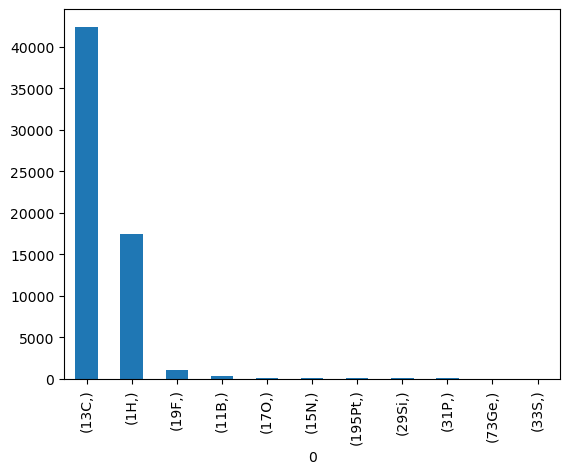

In [10]:
_ = pd.DataFrame(nmr).value_counts().plot(kind="bar")

So, we have a huge number of <sup>13</sup>C spectra, a large number of proton NMR as well, but other isotopes are not very well represented in the data set. For our task, we will now focus on the prediction of <sup>13</sup>C chemical shifts, since this is where we have the most data available.

## Preparing the data to apply ML methods

In its current form, our data is not yet suitable to pass to machine learning algorithm. We currently have a list of molecules and associated spectra, described in text form. The task we want to perform is the prediction of chemical shift of individual atoms in a given molecule. It is a supervised learning task, and more specifically a regression problem, where:
- the label (the value we want to predict) is the chemical shift (in ppm, the standard NMR unit)
- the labeled data is the molecule and identification of the specific atom inside the molecule

In this section, we will prepare (preprocess) our data for that task. In particular, we want to transform our list of molecules into a list of NMR signals/shifts, which means we have to [parse](https://www.merriam-webster.com/dictionary/parse) the current description of the spectra.

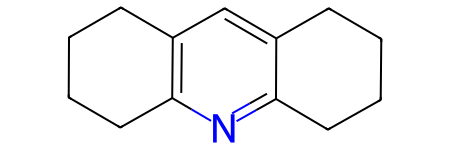

In [11]:
# Display again how the information is currently structured
molecules[48]

For each molecule that has a <sup>13</sup>C NMR spectrum, what we need to do is:
- look at the `NMREDATA_1D_13C` property, which is a list of signals separated by `\`
- for each signal, we have something like this: `1.769, L=s10`. `1.769` is the chemical shift value, `s10` is the identifier of the signal

This gives us a list of NMR signals/peaks, but with no assignment (we do not yet know what atom they correspond to). For that, we need to:
- look a the `NMREDATA_ASSIGNMENT`, which is again a list separated by `\`
- each assignment in the list is like this: `s10, 1.769, 28`. `s10` is the signal name, `1.769` is (again) the chemical shift, and `28` is the atom number corresponding to the peak.

However, we have to be careful, because some signals are attributed to multiple atoms (for reasons of symmetry of the molecule), like this: `s4, 23.2, 2, 12`. Let us try to test a simple function to do all that, and print out the results:

In [12]:
def analyzeSpectrum(mol):
    spectrum = mol.GetProp("NMREDATA_1D_13C")
    assign = mol.GetProp("NMREDATA_ASSIGNMENT")

    # Get a list of peaks
    peaks = {}
    for line in spectrum.split("\\"):
        if "L=" in line:
            shift = line.split(",")[0].strip()
            label = line.split(",")[1].replace("L=", "").strip()
            peaks[label] = shift
    print("Peaks:")
    print(peaks)

    # Get a list of assignments
    assignments = {}
    for line in assign.split("\\"):
        arr = line.split(",")
        if len(arr) > 2:
            label = arr[0].strip()
            shift = arr[1].strip()
            atoms = [x.strip() for x in arr[2:]]
            assignments[label] = (shift, atoms)
    print("Assignments:")
    print(assignments)

In [13]:
analyzeSpectrum(molecules[48])

Peaks:
{'s0': '129.1', 's1': '137.3', 's9': '153.9'}
Assignments:
{'s0': ('129.1', ['10']), 's1': ('137.3', ['9']), 's2': ('153.9', ['8']), 's3': ('22.9', ['1', '13']), 's4': ('23.2', ['2', '12']), 's5': ('28.3', ['4', '14']), 's6': ('32.2', ['3', '11']), 's7': ('129.2', ['6', '10']), 's8': ('137.4', ['9']), 's9': ('153.9', ['5', '8']), 's10': ('1.769', ['28']), 's11': ('1.859', ['26']), 's12': ('2.683', ['30']), 's13': ('2.848', ['24']), 's14': ('7.019', ['23'])}


Our function appears to work. It needs to be expanded a bit, to handle some more cases:
- Some molecules have more than one 13C NMR spectrum. They are numbered like `NMREDATA_1D_13C#2` etc. We need to be able to process all spectra available.
- Convert the values of the chemical shifts from strings to real numbers (`float` in Python terms) and the atom number to integers.
- Have a function that can print more information if we want to debug things (but will be silent when we run it in the final version)
- Make the function output a list of signals, giving for each signal:
  - chemical shift
  - list of atoms attributed

In [14]:
def analyzeSpectrumSmarter(mol, debug=False):
    if not mol:
        # This happens when molecule was buggy and not fully loaded by RDkit
        return None

    # Get all 13C spectra
    spectra = [mol.GetProp(x) for x in mol.GetPropNames() if "NMREDATA_1D_13C" in x]
    if debug:
        print(f"Spectra found: {len(spectra)}")
    if len(spectra) == 0:
        # If the molecule has no 13C spectrum
        return None

    # Get a list of peaks
    peaks = {}
    for spectrum in spectra:
        for line in spectrum.split("\\"):
            if "L=" in line:
                shift = line.split(",")[0].strip()
                label = line.split(",")[1].replace("L=", "").strip()
                peaks[label] = shift
    if debug:
        print("Peaks:")
        print(peaks)

    # Get a list of assignments
    assignments = {}
    assign = mol.GetProp("NMREDATA_ASSIGNMENT")
    for line in assign.split("\\"):
        arr = line.split(",")
        if len(arr) > 2:
            label = arr[0].strip()
            shift = arr[1].strip()
            atoms = [x.strip() for x in arr[2:]]
            assignments[label] = (shift, atoms)
    if debug:
        print("Assignments:")
        print(assignments)

    out = []
    for label, shift in peaks.items():
        if label in assignments:
            atoms = assignments[label][1]
            # Convert the shift to a float value and the atom indices to integers
            out.append((float(shift), [int(at) for at in atoms]))

    return out

In [15]:
# Let's try this!
analyzeSpectrumSmarter(molecules[48], debug=True)

Spectra found: 2
Peaks:
{'s3': '22.9', 's4': '23.2', 's5': '28.3', 's6': '32.2', 's7': '129.2', 's8': '137.4', 's9': '153.9', 's0': '129.1', 's1': '137.3'}
Assignments:
{'s0': ('129.1', ['10']), 's1': ('137.3', ['9']), 's2': ('153.9', ['8']), 's3': ('22.9', ['1', '13']), 's4': ('23.2', ['2', '12']), 's5': ('28.3', ['4', '14']), 's6': ('32.2', ['3', '11']), 's7': ('129.2', ['6', '10']), 's8': ('137.4', ['9']), 's9': ('153.9', ['5', '8']), 's10': ('1.769', ['28']), 's11': ('1.859', ['26']), 's12': ('2.683', ['30']), 's13': ('2.848', ['24']), 's14': ('7.019', ['23'])}


[(22.9, [1, 13]),
 (23.2, [2, 12]),
 (28.3, [4, 14]),
 (32.2, [3, 11]),
 (129.2, [6, 10]),
 (137.4, [9]),
 (153.9, [5, 8]),
 (129.1, [10]),
 (137.3, [9])]

It works! But are how those atom numbers attributed? After reading the documentation, they simply follow the order of atoms in the original SDF file provided, so it is the same numbering that RDkit read with the molecule. We can display the atom numbers with this bit of code:

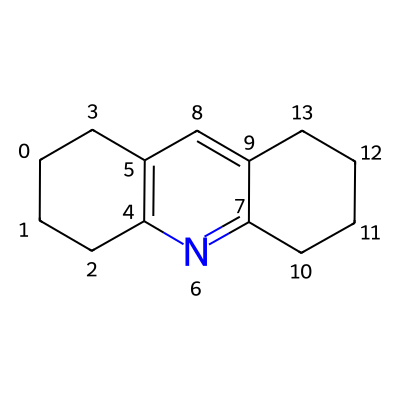

In [16]:
from rdkit.Chem.Draw import IPythonConsole

IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 400,400
molecules[48]

The assignment of signals (if you remember your NMR courses) is logical. But we see doing a careful check that there is one difference: RDkit numbers atoms from zero, while the NMR assingment starts numbering at one. We will need to be remember that. For now, we can process all the spectra in the database, and store the spectra and associated molecules in a big list. It can take a bit of time (30 seconds on my laptop).

In [17]:
%%time

nmrdata = []
for mol in molecules:
    data = analyzeSpectrumSmarter(mol)
    if data:
        nmrdata.append((data,mol))

CPU times: user 25.5 s, sys: 62 ms, total: 25.5 s
Wall time: 25.7 s


In [18]:
# How many molecules have we got with at least one valid 13C spectrum?
len(nmrdata)

37709

In [19]:
# How many values of chemical shift have we extracted? This will be the real size of our training data set.
allshifts = [peak[0] for data in nmrdata for peak in data[0]]
len(allshifts)

399985

That is a huge number! We have almost 400,000 individual chemical shifts in the data base, showing why a data-based approach to prediction is a good idea: we have a lot of data to train our algorithm on. Before we go further, let us take a quick look at the properties of this distribution of <sup>13</sup>C chemical shifts.

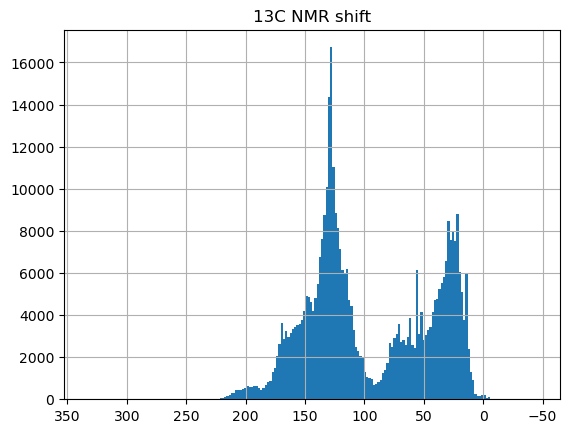

In [20]:
ax = pd.DataFrame(allshifts, columns=["13C NMR shift"]).hist(bins=200)
# Invert the x axis because NMR spectra are historically displayed with negative shifts on the right
ax[0][0].invert_xaxis()

In [21]:
pd.DataFrame(allshifts, columns=["13C NMR shift"]).describe()

,13C NMR shift
count,399985.000000
mean,95.640157
std,52.004324
min,-45.800000
25%,41.700000
50%,114.400000
75%,134.300000
max,333.800000


We have a nice distrubtion, and if you look at [NMR tables](https://www2.chem.wisc.edu/deptfiles/OrgLab/handouts/13-C%20NMR%20Chemical%20Shift%20Table.pdf) you can already see the different common types of carbon atoms as peaks in the distribution (aliphatic, aromatic, carbonyl, etc).

## Identifying descriptors of chemical environment

We now have a list of chemical shifts, as well as corresponding atoms and the molecules they belong to. In order to train a predictor for the chemical shifts, we now need to encode the chemical information into a series of features, or descriptors. When we predict molecular properties (like solubility, melting point, etc) we naturally use molecular descriptors (molecular weight, number of aromatic rings, etc). In this case, our task is different: we want to predict properties of specific atoms in the molecule. Therefore, the descriptors we will create will not be descriptor of the whole molecule, but descriptors of the atom and its environment.

That makes sense from the chemical point of view as well: we know that the chemical shift is heavily influenced by the electronic density and the chemical environment, so while creating our list of descriptors, we will have to consider things like:
- what atoms is the C atom bonded to?
- what type of bonds (single, double)?
- is it in an aromatic ring?

In this section, we create for each carbon a series of chemical descriptors of its environment.

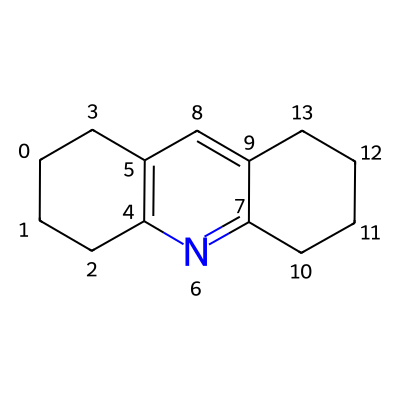

In [22]:
# Let's look at a molecule again
molecules[48]

In [23]:
# Using RDkit, we can get look at its atoms
molecules[48].GetAtoms()[7]

In [24]:
# From the atoms, we can get their neighbors (atoms bonded to the chosen atom)
molecules[48].GetAtoms()[7].GetNeighbors()

(<rdkit.Chem.rdchem.Atom at 0x16ba91d20>,
 <rdkit.Chem.rdchem.Atom at 0x16ba91e00>)

In [25]:
# And RDkit provides us a way to look up various properties of an atom: atomic number, hybridization, aromatic, etc
at = molecules[48].GetAtoms()[7]
[at.GetAtomicNum(), at.GetHybridization(), at.GetIsAromatic(), at.IsInRingSize(5)]

[6, rdkit.Chem.rdchem.HybridizationType.SP2, True, False]

In [26]:
# We can get a list of the functions (and properties) that are supported by RDkit for atoms using the dir() function.
# Functions related to properties are called GetSomething() or SiSomething()
[func for func in dir(at) if "Get" in func or "Is" in func]

['GetAtomMapNum',
 'GetAtomicNum',
 'GetBonds',
 'GetBoolProp',
 'GetChiralTag',
 'GetDegree',
 'GetDoubleProp',
 'GetExplicitBitVectProp',
 'GetExplicitValence',
 'GetFormalCharge',
 'GetHybridization',
 'GetIdx',
 'GetImplicitValence',
 'GetIntProp',
 'GetIsAromatic',
 'GetIsotope',
 'GetMass',
 'GetMonomerInfo',
 'GetNeighbors',
 'GetNoImplicit',
 'GetNumExplicitHs',
 'GetNumImplicitHs',
 'GetNumRadicalElectrons',
 'GetOwningMol',
 'GetPDBResidueInfo',
 'GetProp',
 'GetPropNames',
 'GetPropsAsDict',
 'GetQueryType',
 'GetSmarts',
 'GetSymbol',
 'GetTotalDegree',
 'GetTotalNumHs',
 'GetTotalValence',
 'GetUnsignedProp',
 'IsInRing',
 'IsInRingSize',
 'SetIsAromatic',
 'SetIsotope']

So, what descriptors do we want to include in our model? This is where our chemical knowledge (or intuition) comes into play. We know that the atomic environment is key, so we will want to include information about the atom, and also about its neighbors. Among properties of the atom, we can include:
- its hybridization state (sp, sp2, sp3)
- the number of H atoms it is linked to
- its formal charge
- is it aromatic?
- is it in a ring of size 3, 4, 5, 6, 7?

About its neighbors, we can include information such as:
- their atomic number
- their formal charge
- their electronegativity
- their electron affinity
- are they aromatic

Because a C atom can have between one and four neighboring atoms, these neighbor properties are not unique. The choice made here is, for each property, to describe: the min value, the max value, the average, and the standard-deviation. This allows to characterize the diversity of the environment and the statistical distribution of the values.

In [27]:
def min_max_avg_stddev(values):
    """
    For a list of values, return the minimum, maximum, average, and standard-deviation as floats.
    """
    n = len(values)
    avg = float(sum(values)) / n
    stddev = math.sqrt(sum((x - avg)**2 for x in values) / n) 
    return [float(min(values)), float(max(values)), avg, stddev]

def generateDescriptors(molecule, atom_index):
    """
    For an atom with a given index in the molecule, return its descriptors as a list
    """
    at = molecule.GetAtoms()[atom_index]
    neigh = at.GetNeighbors()

    neigh_z = [x.GetAtomicNum() for x in neigh]
    neigh_formalcharge = [x.GetFormalCharge() for x in neigh]
    neigh_arom = [0 if x.GetIsAromatic() else 1 for x in neigh]
    # We use the mendeleev module to look up values of electronegativity and electron affinity
    neigh_electroneg = [mendeleev.element(z).en_pauling for z in neigh_z]
    neigh_electronaff = [mendeleev.element(z).electron_affinity for z in neigh_z]

    return [str(at.GetHybridization()),
            at.GetIsAromatic(),
            at.IsInRingSize(3),
            at.IsInRingSize(4),
            at.IsInRingSize(5),
            at.IsInRingSize(6),
            at.IsInRingSize(7),
            at.GetTotalNumHs(),
            at.GetFormalCharge(),
            # For each neighbors property, we add the four descriptors: min, max, avg, stddev
            *min_max_avg_stddev(neigh_z),
            *min_max_avg_stddev(neigh_formalcharge),
            *min_max_avg_stddev(neigh_arom),
            *min_max_avg_stddev(neigh_electroneg),
            *min_max_avg_stddev(neigh_electronaff),
           ]

In [28]:
generateDescriptors(molecules[48], 7)

['SP2',
 True,
 False,
 False,
 False,
 True,
 False,
 0,
 0,
 6.0,
 7.0,
 6.333333333333333,
 0.4714045207910317,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.3333333333333333,
 0.4714045207910317,
 2.55,
 3.04,
 2.7133333333333334,
 0.23098821518760562,
 -1.4,
 1.262119,
 0.374746,
 1.2549349314837004]

We now have our function returning all the descriptors for each atom. We want to apply this function to all atoms for which we have an associated 13C NMR shift, in all molecules. We begin by trying this at a small scale, with 30 molecules only: 

In [29]:
%%time

alldata = []
nerrors = 0
for peaks, mol in nmrdata[:30]:
    for shift, atoms in peaks:
        for atom in atoms:
            # Atoms are numbered from 1 in the NMR assignment, but start at 0 for RDKit
            try:
                alldata.append([shift, *generateDescriptors(mol, atom-1)])
            except:
                # Sometimes we fail, because NMR assignment is invalid (references atoms that do not exist)
                nerrors += 1

print(f"Number of records generated: {len(alldata)}")
print(f"Number of errors: {nerrors}")

Number of records generated: 629
Number of errors: 6
CPU times: user 3min 7s, sys: 2.23 s, total: 3min 9s
Wall time: 3min 10s


Well, it is not fast: the calculation of neighbors, their properties, etc is relatively slow. It took more than three minutes to process 629 records, and we have 400,000 in the whole database. That would take one and a half day!

On the other hand, 629 data records is definitely not enough for us to do proper learning. And they come from only 30 molecules, so there is a lack of diversity which means we would not get good generalization. Looking at the numbers, we should be able to process about 4000 molecules in less than five hours (this is running on my laptop), so we will do that.

## Calculating all the descriptors

This is the code I ran to compute all the descriptors. **⚠️ To avoid this calculation you can directly load the resulting data, see below.**

In [30]:
%%time

alldata = []
nerrors = 0
n = 0
for peaks, mol in random.sample(nmrdata, 4000):
    n += 1
    if n % 200 == 0:
        print(f"Molecule {n}")
    for shift, atoms in peaks:
        for atom in atoms:
            # Atoms are numbered from 1 in the NMR assignment, but start at 0 for RDKit
            try:
                alldata.append([shift, *generateDescriptors(mol, atom-1)])
            except:
                # Sometimes we fail, because NMR assignment is invalid (references atoms that do not exist)
                nerrors += 1

print(f"Number of records generated: {len(alldata)}")
print(f"Number of errors: {nerrors}")

Molecule 200
Molecule 400
Molecule 600
Molecule 800
Molecule 1000
Molecule 1200
Molecule 1400
Molecule 1600
Molecule 1800
Molecule 2000
Molecule 2200
Molecule 2400
Molecule 2600
Molecule 2800
Molecule 3000
Molecule 3200
Molecule 3400
Molecule 3600
Molecule 3800
Molecule 4000
Number of records generated: 49349
Number of errors: 106
CPU times: user 4h 4min 22s, sys: 2min 36s, total: 4h 6min 58s
Wall time: 4h 7min 16s


We now transform this list of properties into a nice dataframe, with column headers corresponding to the descriptors we have created.

In [31]:
def neigh_labels(x):
    return ["neigh_" + x + "_min", "neigh_" + x + "_max", "neigh_" + x + "_avg", "neigh_" + x + "_stddev"]
data_columns = ["shift", "hybridization", "aromatic", "ring3", "ring4", "ring5", "ring6", "ring7", "numHs", "charge",
                *neigh_labels("z"), *neigh_labels("charge"), *neigh_labels("aromatic"),
                *neigh_labels("eneg"), *neigh_labels("eaff")]

df = pd.DataFrame(alldata, columns=data_columns)

In [32]:
df.head()

,shift,hybridization,aromatic,ring3,ring4,ring5,ring6,ring7,numHs,charge,...,neigh_aromatic_avg,neigh_aromatic_stddev,neigh_eneg_min,neigh_eneg_max,neigh_eneg_avg,neigh_eneg_stddev,neigh_eaff_min,neigh_eaff_max,neigh_eaff_avg,neigh_eaff_stddev
0,25.1,SP3,False,False,False,False,False,False,3,0,...,1.0,0.0,2.55,2.55,2.5500,0.000000,1.262119,1.262119,1.262119,0.000000
1,25.1,SP3,False,False,False,False,False,False,3,0,...,1.0,0.0,2.55,2.55,2.5500,0.000000,1.262119,1.262119,1.262119,0.000000
2,78.8,SP3,False,False,False,False,False,False,0,0,...,1.0,0.0,2.55,3.44,2.7725,0.385381,1.262119,1.461113,1.311868,0.086167
3,98.0,SP2,True,False,False,False,True,False,1,0,...,0.0,0.0,2.55,2.55,2.5500,0.000000,1.262119,1.262119,1.262119,0.000000
4,105.5,SP2,True,False,False,False,True,False,1,0,...,0.0,0.0,2.55,2.55,2.5500,0.000000,1.262119,1.262119,1.262119,0.000000


In [33]:
# And we save to a CSV file, so we can reuse it later without having to recompute everything
df.to_csv("nmrdata_13C.csv", index_label=False)
df.to_excel("nmrdata_13C.xlsx")

**Important: to load the data directly, without running the calculations, you can skip the lines above and read directly from the file by running the cell below:**

In [ ]:
df = pd.read_csv("nmrdata_13C.csv")
print("Number of records read: ", len(df))

## Building a machine learning model

We now have preprocessed data, ready for training models. In the dataframe `df`, the first column (`shift`) is the label, and the other columns are the various descriptors.

In [35]:
print("Number of records (signals) available: ", len(df))
df.describe()

Number of records (signals) available:  49349


,shift,numHs,charge,neigh_z_min,neigh_z_max,neigh_z_avg,neigh_z_stddev,neigh_charge_min,neigh_charge_max,neigh_charge_avg,...,neigh_aromatic_avg,neigh_aromatic_stddev,neigh_eneg_min,neigh_eneg_max,neigh_eneg_avg,neigh_eneg_stddev,neigh_eaff_min,neigh_eaff_max,neigh_eaff_avg,neigh_eaff_stddev
count,49349.000000,49349.000000,49349.000000,49349.000000,49349.000000,49349.000000,49349.000000,49349.000000,49349.000000,49349.000000,...,49349.000000,49349.000000,49349.000000,49349.000000,49349.000000,49349.000000,49349.000000,49349.000000,49349.000000,49349.000000
mean,95.809794,1.120124,-0.000020,6.122981,7.334110,6.614187,0.574020,0.000365,0.006971,0.002996,...,0.578556,0.100032,2.572567,2.811742,2.675387,0.112943,0.947885,1.353473,1.165149,0.192732
std,51.526480,1.006986,0.013505,1.022331,4.123831,1.856873,1.914278,0.037119,0.083444,0.042982,...,0.443102,0.193619,0.152311,0.385860,0.216637,0.174606,0.868701,0.463458,0.475120,0.428630
min,-21.500000,0.000000,-1.000000,3.000000,3.000000,3.000000,0.000000,-1.000000,-1.000000,-1.000000,...,0.000000,0.000000,0.980000,0.980000,0.980000,0.000000,-1.400000,-1.400000,-1.400000,0.000000
25%,41.200000,0.000000,0.000000,6.000000,6.000000,6.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.550000,2.550000,2.550000,0.000000,1.262119,1.262119,1.262119,0.000000
50%,115.600000,1.000000,0.000000,6.000000,6.000000,6.000000,0.000000,0.000000,0.000000,0.000000,...,0.666667,0.000000,2.550000,2.550000,2.550000,0.000000,1.262119,1.262119,1.262119,0.000000
75%,133.000000,2.000000,0.000000,6.000000,8.000000,6.666667,0.500000,0.000000,0.000000,0.000000,...,1.000000,0.000000,2.550000,3.040000,2.795000,0.245000,1.262119,1.461113,1.262119,0.093807
max,227.400000,3.000000,1.000000,52.000000,53.000000,52.000000,23.500000,1.000000,1.000000,1.000000,...,1.000000,0.500000,3.440000,3.980000,3.845000,0.785000,2.077104,3.612725,3.025074,2.506362


Let's plot some of the descriptors, and their correlation with chemical shifts. We see, for example that the chemical shift distributions are very different for sp3, sp2 and sp carbon atoms:

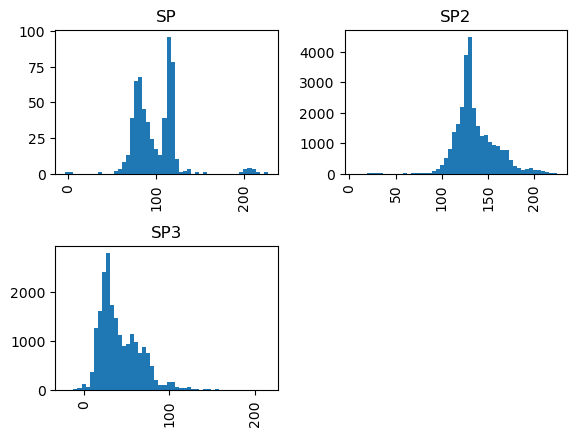

In [36]:
_ = df.hist("shift", by="hybridization", bins=50)

The same is true for the number of bonded hydrogen atoms:

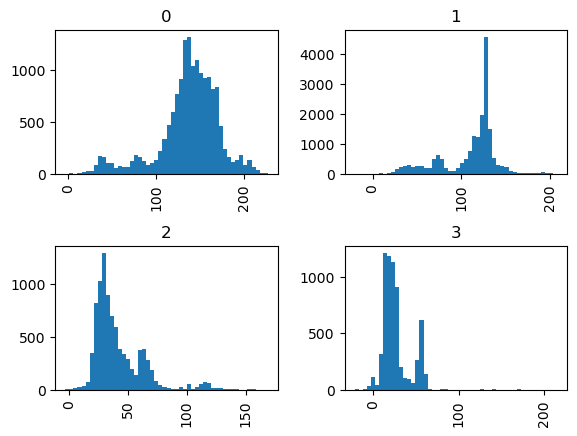

In [37]:
_ = df.hist("shift", by="numHs", bins=50)

And there is also some form of correlation between the average electronegativity of the neighboring atoms and the chemical shift:

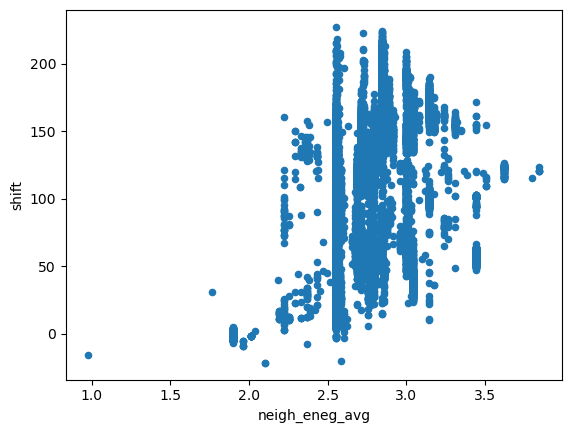

In [38]:
_ = df.plot.scatter("neigh_eneg_avg", "shift")

We now turn to the building of our model. We will store:
- the chemical shifts in the `target` variable
- all other fields (the descriptors) in the `data` variable

Then, we look up what the types of each descriptor is:

In [39]:
data = df.drop(["shift"], axis=1)
target = df["shift"]

data.dtypes

hybridization             object
aromatic                    bool
ring3                       bool
ring4                       bool
ring5                       bool
ring6                       bool
ring7                       bool
numHs                      int64
charge                     int64
neigh_z_min              float64
neigh_z_max              float64
neigh_z_avg              float64
neigh_z_stddev           float64
neigh_charge_min         float64
neigh_charge_max         float64
neigh_charge_avg         float64
neigh_charge_stddev      float64
neigh_aromatic_min       float64
neigh_aromatic_max       float64
neigh_aromatic_avg       float64
neigh_aromatic_stddev    float64
neigh_eneg_min           float64
neigh_eneg_max           float64
neigh_eneg_avg           float64
neigh_eneg_stddev        float64
neigh_eaff_min           float64
neigh_eaff_max           float64
neigh_eaff_avg           float64
neigh_eaff_stddev        float64
dtype: object

Most of the descriptors are numerical, either integers (`int64`) or reals (`float64`). We have some boolean variables (`aromatic`, `ring*`) and one categorical descriptor (`hybridization`). Here, we will train a simple linear regression model, therefore we need to:
- encode the categorical feature: we will use a [one-hot encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)
- scale all the features

We combine all these steps in a single pipeline:

In [40]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Use one-hot encoding for hybridization only
transformer = ColumnTransformer(transformers=[('hybridization_encoder', OneHotEncoder(), ["hybridization"])], remainder='passthrough')
# Combine all steps in a pipeline
model = Pipeline(steps=[("preprocessor", transformer), ("scaling", StandardScaler()), ("regression", LinearRegression())])
# Fit the resulting model
model.fit(data, target)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('hybridization_encoder',
                                                  OneHotEncoder(),
                                                  ['hybridization'])])),
                ('scaling', StandardScaler()),
                ('regression', LinearRegression())])

In [41]:
# Evaluate the model (training score)
from sklearn.metrics import mean_absolute_error
mean_absolute_error(target, model.predict(data))

8.395169782820107

So, we have created and fitted a linear model, using all the data available. The mean average error for this model is about 8 ppm, which is not bad for a first try! That's the training error, since we trained on all the data, and tested on the same set. Can we compare this number to something else?

In [42]:
from sklearn.dummy import DummyRegressor
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(data, target)

DummyRegressor()

In [43]:
mean_absolute_error(target, dummy_regr.predict(data))

46.41330141496532

So our MAE of ~8 ppm compares to an MAE of 46 ppm, for a dummy model, which would also predict the mean of the data set. Therefore, we do better than “pure luck”. Let us plot the results, with the true chemical shift as X, and the predicted value as Y:

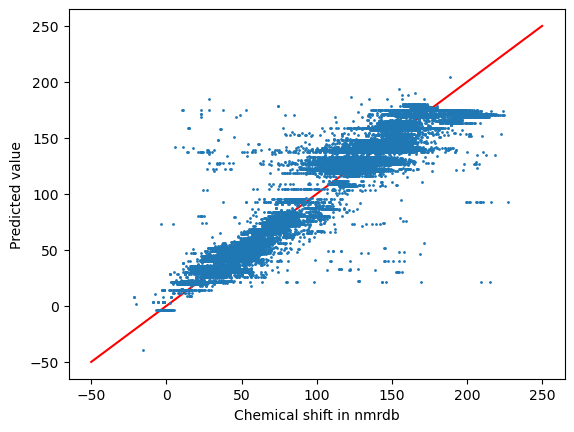

In [45]:
# Plot the data
ax = pd.DataFrame({"x": target, "y": model.predict(data)}).plot.scatter("x", "y", s=1)
# Add a diagonal line
ax.plot([-50,250], [-50, 250], 'r-', zorder=0)
# Set axes labels
ax.set_xlabel("Chemical shift in nmrdb")
ax.set_ylabel("Predicted value");

Nice!

## Interpreting the model

Can we now interpret this model? Linear models are famously known for their ease of interpretation, so we can look at the coefficients of the fitted model.

In [46]:
# Extract the coefficients of the linear regression
model.named_steps["regression"].coef_

array([ 5.90343074e+11,  2.71371703e+12,  2.70415579e+12, -3.38448713e+00,
       -1.30692753e+00,  3.46649289e-01,  5.76802832e-01,  1.19974701e+00,
        2.66025647e-01, -9.21234624e+00,  3.65693573e-01, -3.97107741e+00,
        9.29778346e+00,  3.23965865e+00, -1.34719351e+01, -3.40465906e-01,
        8.59083656e-01,  2.11218672e-01, -9.09787109e-01,  2.57171613e+01,
       -3.55611056e+01,  1.24295879e+01,  2.63399153e+01,  2.85112915e+00,
        1.76928547e+00,  3.46901657e+00,  1.01994931e+01, -9.26074386e+00,
        5.04205250e+00, -7.90769277e-01, -1.11471215e+01])

Uh oh. We have some very large coefficients, of the order of 10<sup>12</sup>. What is happening, can you guess _before reading below_?

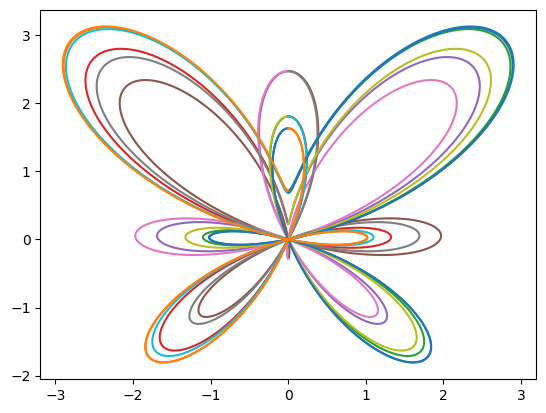

In [47]:
# This nice butterfly plot has nothing to do with our exercices.
# It is here to let you take a pause, think about the question above
# before you continue reading below :)

def butterfly_curve(t):
    # Code from https://stackoverflow.com/a/69569638
    c, s = np.cos(t), np.sin(t)
    r = (np.exp(c)-2*np.cos(4*t)-(np.sin((t/12)))**5)
    return s*r, c*r

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
t = np.linspace(0, np.pi, 301)
for n in range(12):
    ax.plot(*butterfly_curve(t))
    t += np.pi

OK, why are there extremely large coefficients in the linear regression? Because the descriptors are strongly correlated, and this means that the coefficients of the regression become ill-defined. You can read more there: https://datascience.stackexchange.com/q/24452

In order to avoid regression coefficients becoming very large, the standard technique is called [regularization](https://inria.github.io/scikit-learn-mooc/python_scripts/linear_models_regularization.html). We will use here a variant of linear regression called [Ridge regression](https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression-and-classification), which imposes a penalty on the size of the coefficients. We won't look too much into the details at this point, in particular, we will use a single value of the alpha coefficient for regularization (instead of tuning it).

In [48]:
from sklearn.linear_model import Ridge

model2 = Pipeline(steps=[("preprocessor", transformer), ("scaling", StandardScaler()), ("regression", Ridge(alpha=1.))])
model2.fit(data, target)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('hybridization_encoder',
                                                  OneHotEncoder(),
                                                  ['hybridization'])])),
                ('scaling', StandardScaler()), ('regression', Ridge())])

In [49]:
mean_absolute_error(target, model2.predict(data))

8.396108969633648

In [50]:
model2.named_steps["regression"].coef_

array([ -0.05630242,  21.78329231, -21.84802143,  -3.55046781,
        -1.30524956,   0.3467462 ,   0.58039539,   1.20710732,
         0.26623473,  -9.19413587,   0.36530766,  -3.76878645,
         8.63811964,   3.16746205, -12.77236512,  -0.29908543,
         0.77180721,   0.20724062,  -0.82336234,  21.47179656,
       -31.40963988,  12.02999547,  22.75524405,   2.771413  ,
         1.91690027,   3.49743948,  10.03413246,  -9.04078449,
         4.92145181,  -0.78085346, -10.90745844])

What does that mean? Well, regularization leads to a model with comparable accuracy (MAE is still ~8 ppm) and with coefficients that now have a reasonable order of magnitude. We can interpret each coefficient as the “weight” of each feature in the final model. The simplest way is to put them all on a graph:

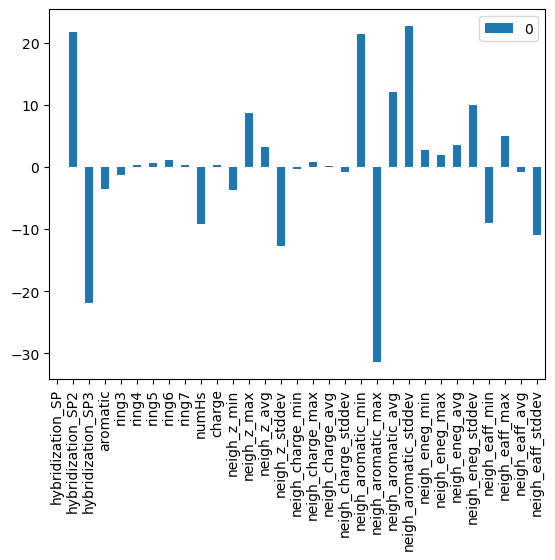

In [51]:
# Extract the features names from the model, and make them a bit shorter 
features = [x.split("__")[1] for x in model2.named_steps["preprocessor"].get_feature_names_out()]
# Plot the coefficients as bar chart
_ = pd.DataFrame(model2.named_steps["regression"].coef_, index=features).plot.bar()

It makes sense that hybridization, number of H atoms, the atomic number of neighboring atoms, aromaticity and electronegativity are the most important features, I think. The ring sizes, on the other hand, clearly play no role.

## Let's not forget to cross-validate!

We have quantified our model above using the test error, which is something we know is a very bad idea. It gives us a first rough estimate, but could be falsely reassuring if our model was overfitting. I will not do here a full validation (but you should!)… but just a basic sanity check:

In [52]:
from sklearn.model_selection import cross_validate

res = cross_validate(model2, data, target, scoring="neg_mean_absolute_error", return_train_score=True)
print("Average of test score (MAE): ", np.abs(np.mean(res["test_score"])))
res

Average of test score (MAE):  8.409279813460904


{'fit_time': array([0.10637975, 0.08782315, 0.08714175, 0.09189415, 0.09330511]),
 'score_time': array([0.01534724, 0.01574397, 0.01446915, 0.01498103, 0.01559091]),
 'test_score': array([-8.29716775, -8.44468815, -8.26036069, -8.60209619, -8.44208628]),
 'train_score': array([-8.42742542, -8.38845407, -8.4241949 , -8.35086505, -8.38905863])}

The MAE of the test score upon five-fold cross-validation remains about the same value (~8 ppm), which is a good validation.

## To go further

- The effet of solvent is know to be very important, but we have discarded it completely here. How can you take it into account? Does it help in obtaining better statistical accuracy for the predictor?
- What is the impact of the quantity of available data? This is an very important concept called “data efficiency”: how much does the accuracy of the trained model depend on the amount of data it was trained on? This is important to investigate, especially if you want to make predictors for isotopes that have less data than <sup>13</sup>C.
- Nature of the model: we have only tested above a simple linear regression model (with regularization). How do other types of model perform for the same task, trained with the same data? Be careful to avoid overfitting, though!
- Here we have only considered some properties of nearest neighbors, i.e., the atoms directly bonded to the C center. How can we take into account further neighbors? It is possible to use hand-made descriptors (as above), or to rely on atom-based fingerprints. [Morgan fingerprints](https://www.rdkit.org/docs/GettingStartedInPython.html#morgan-fingerprints-circular-fingerprints), for example, can be calculated in RDkit with a given radius (number of neighbors taken into account) and centered on a specific atom (with the `fromAtoms` argument to the `GetFingerprint` function).
- Instead of looking at the physical properties of neighboring atoms, another approach is called the family of [group contribution methods](https://en.wikipedia.org/wiki/Group-contribution_method). In these, you try to recognize groups of atoms bonded to the central atom, through patterns, and fit their potential “contributions”. It is also a statistical learning approach, but it will use as descriptors an encoding of the groups present or not. Can it provide a better accuracy than our model above?